## Import Libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import json
import ast
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from transformers import DataCollatorForTokenClassification

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from tqdm import tqdm

# from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## Define NER Label

In [4]:
# Info: Transformers (huggingface) is quite different from pytorch
label_names = ["B-SBJ", "B-MDL", "B-ACT", "B-OBJ", "B-QTY", "B-QVA",
               "I-SBJ", "I-MDL", "I-ACT", "I-OBJ", "I-QTY", "I-QVA",
               "O"]
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

## Download Model

In [5]:
# # Use a pipeline as a high-level helper
# from transformers import pipeline

# pipe = pipeline("token-classification", model="kiipliwooke/KIPBERT")

# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("indolem/indobert-base-uncased", label2id=label2id, id2label=id2label)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pipe("Bagaimana bunyi Pasal 23 dalam Peraturan Pemerintah Republik Indonesia Nomor 87 Tahun 2013")

NameError: name 'pipe' is not defined

## Save Model to local - Example

In [ ]:
# save_path = 'model/'

# model_ner_path = os.path.join(save_path, "indobert_ner"+".pth")

# torch.save(model_ner, model_ner_path)

## Load Model - Example

In [7]:
# save_path = 'model/'
# model_ner_path = os.path.join(save_path, "indobert_ner"+".pth")

# bert_ner = torch.load(model_ner_path)

# bert_ner = pipe
bert_ner = model

In [8]:
bert_ner

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [9]:
bert_ner.config.num_labels

13

In [11]:
bert_ner.config.id2label

{0: 'B-SBJ',
 1: 'B-MDL',
 2: 'B-ACT',
 3: 'B-OBJ',
 4: 'B-QTY',
 5: 'B-QVA',
 6: 'I-SBJ',
 7: 'I-MDL',
 8: 'I-ACT',
 9: 'I-OBJ',
 10: 'I-QTY',
 11: 'I-QVA',
 12: 'O'}

In [10]:
print(bert_ner)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

# LexID QA 2 Using BERT

## Dataset Class

In [12]:
class Lexidqa2Dataset(Dataset):
  """LexID QA2 Dataset"""

  def __init__(self, dataframe, tokenizer):
    """
      dataframe (Pandas DataFrame): Dataset in DataFrame format
      tokenizer (Tokenizer) : Sentence to Vector
    """
    self.qa_frame = dataframe
    self.tokenizer = tokenizer

    label_names = ["B-SBJ", "B-MDL", "B-ACT", "B-OBJ", "B-QTY", "B-QVA",
                  "I-SBJ", "I-MDL", "I-ACT", "I-OBJ", "I-QTY", "I-QVA",
                  "O"]
    self.id2label = {i: label for i, label in enumerate(label_names)}
    self.label2id = {v: k for k, v in id2label.items()}

  def __len__(self):
    return len(self.qa_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    question = self.qa_frame.loc[idx, "question"]
    question_tokenized = tokenizer(question, truncation=True)
    question_input_ids = torch.tensor(question_tokenized['input_ids'])
    question_token_type_ids = torch.tensor(question_tokenized['token_type_ids'])
    question_attention_masks = torch.tensor(question_tokenized['attention_mask'])

    answer = self.qa_frame.loc[idx, "answer"]
    ner = torch.tensor([self.label2id[id] for id in ast.literal_eval(self.qa_frame.loc[idx, "ner"])])
    ner = self.align_labels_with_tokens(ner, question_tokenized.word_ids(), question_tokenized.tokens(), question).long()
    # ner = torch.stack([self.one_hot(label, self.label2id) for label in ner if label != -100])

    sample = (question,
              question_input_ids,
              question_token_type_ids,
              question_attention_masks,
              answer,
              ner)

    return sample

  def align_labels_with_tokens(self, labels, word_ids, tokens, question):
    for index, token in enumerate(tokens):
      if token == '-':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == '/':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == ',':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == '?':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == '.':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif tokens[index-1] == '-':  # Because the '-' have been deleted
        id = word_ids[index-1]
        if question.split(' ')[id][-1] != '-': # Check if the gold question concatenated between the special character or not
          for i in range(index, len(word_ids)):
            if word_ids[i] is not None:
              word_ids[i] -= 1
      elif tokens[index-1] == '/':  # Because the '/' have been deleted
        id = word_ids[index-1]
        if question.split(' ')[id][-1] != '/': # Check if the gold question concatenated between the special character or not
          for i in range(index, len(word_ids)):
            if word_ids[i] is not None:
              word_ids[i] -= 1
      elif tokens[index-1] == ',':  # Because the ',' have been deleted
        id = word_ids[index-1]
        if question.split(' ')[id][-1] != ',': # Check if the gold question concatenated between the special character or not
          for i in range(index, len(word_ids)):
            if word_ids[i] is not None:
              word_ids[i] -= 1

    new_labels = []
    current_word = None
    for word_id in word_ids:
      if word_id != current_word:
        # Start of a new word!
        current_word = word_id
        label = -100 if word_id is None else labels[word_id]
        new_labels.append(label)
      elif word_id is None:
        # Special token
        new_labels.append(-100)
      else:
        # Same word as previous token
        label = labels[word_id]
        new_labels.append(label)

    return torch.Tensor(new_labels)

  def one_hot(self, label, label2id):
    one_hot_label = torch.zeros(len(label2id))
    one_hot_label[int(label)] = 1

    return one_hot_label

## Dataset

In [13]:
train_semantic_df = pd.read_csv('semantic/dataset/train_semantic.csv')
test_semantic_df = pd.read_csv('semantic/dataset/test_semantic.csv')

qa_dataset = Lexidqa2Dataset(train_semantic_df, tokenizer)

In [14]:
train_semantic_df.loc[151]['question'], train_semantic_df.loc[151]['ner']

('Apakah orang yang melakukan penyuluhan pertanian, perikanan, kehutanan yang menimbulkan kerugian sosial ekonomi dapat dipidana?',
 "['O', 'B-SBJ', 'O', 'B-ACT', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'I-OBJ', 'O', 'B-ACT', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'B-MDL', 'B-ACT']")

In [15]:
qa_dataset[0]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


('Sebagai Bank Accd, apakah Prinsip Umum Perizinan Dapat Berkondisi Pembawaan Uka',
 tensor([    3,  1624,  2747, 11215,   933,    16,  2811,  4174,  2047, 22155,
          1708, 11178,  2510,  9115,  1476,  3360,   936,     4]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'Ya',
 tensor([-100,    4,    5,   11,   11,   11,   12,    0,    6,    6,    1,    2,
            2,    3,    3,    9,    9, -100]))

Sample

In [ ]:
tokenizer("Undang-Undang Republik Indonesia Nomor 7 Tahun 1967 dibuat dengan menimbang-nimbang apa").tokens()

['[CLS]',
 'undang',
 '-',
 'undang',
 'republik',
 'indonesia',
 'nomor',
 '7',
 'tahun',
 '1967',
 'dibuat',
 'dengan',
 'menimbang',
 '-',
 'nim',
 '##bang',
 'apa',
 '[SEP]']

In [ ]:
tokenizer("Apakah Peraturan Menteri Keuangan Republik Indonesia Nomor 218 Tahun 2014 ini pernah diameliorasi").tokens()

['[CLS]',
 'apakah',
 'peraturan',
 'menteri',
 'keuangan',
 'republik',
 'indonesia',
 'nomor',
 '21',
 '##8',
 'tahun',
 '2014',
 'ini',
 'pernah',
 'diam',
 '##eli',
 '##orasi',
 '[SEP]']

In [ ]:
print(qa_dataset[7179])

Undang-Undang Republik Indonesia Nomor 7 Tahun 1967 dibuat dengan menimbang-nimbang apa
['[CLS]', 'undang', '-', 'undang', 'republik', 'indonesia', 'nomor', '7', 'tahun', '1967', 'dibuat', 'dengan', 'menimbang', '-', 'nim', '##bang', 'apa', '[SEP]']
('Undang-Undang Republik Indonesia Nomor 7 Tahun 1967 dibuat dengan menimbang-nimbang apa', tensor([3.0000e+00, 2.6130e+03, 1.7000e+01, 2.6130e+03, 3.4890e+03, 1.7180e+03,
        3.2860e+03, 2.7000e+01, 1.6200e+03, 8.9900e+03, 3.2300e+03, 1.5450e+03,
        1.7572e+04, 1.7000e+01, 1.8615e+04, 2.0960e+03, 2.0640e+03, 4.0000e+00]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), '1. Bahwa dipandang perlu memberikan penghargaan kepada mereka yang telah menyumbangkan tenaganya secara aktif atas dasar sukarela dalam ikatan kesatuan bersenjata (resmi maupun kelaskaran) dalam memperjuangkan, membela dan mempertahankan Kemerdekaan N

In [ ]:
for i in range(len(qa_dataset)):
  sample = qa_dataset[i]

  print(i, sample[0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.random.seed(12345)
random_indices = np.random.choice(range(len(qa_dataset)), size=5, replace=False)

for i in random_indices:
  sample = qa_dataset[i]

  print(i, sample[0])

  if i == 5:
    break

5710 Kapan terjadinya pengukugannya Peraturan Menteri Keuangan Republik Indonesia Nomor 204 Tahun 2015 ini keluar
21038 Apakah isi Pasal 2 dalam Peraturan Menteri Kelautan Dan Perikanan Republik Indonesia Nomor 25 Tahun 2012 itu
19978 Berapa jumlah pasal yang tersusun di Peraturan Pemerintah Republik Indonesia Nomor 26 Tahun 2016 tersebut
29131 Sudahkah Peraturan Menteri Perhubungan Republik Indonesia Nomor 41 Tahun 2012 tersebut dilakukan penyempurnaan
26026 Peraturan Komisi Pemilihan Umum Republik Indonesia Nomor 10 Tahun 2015 tersebut terjadi penganuliran pasal-pasal mana saja


## Split, DataLoader

In [16]:
def collate_fn_class(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, input_ids, _, attentions, _, ner_labels = zip(*data)
    features = pad_sequence(input_ids, batch_first=True)
    masks = pad_sequence(attentions, batch_first=True)
    targets = pad_sequence(ner_labels, batch_first=True, padding_value=-100)
    return features, masks, targets

    # max_len = max(lengths)
    # n_ftrs = data[0][0].size(1)
    # features = torch.zeros((len(data), max_len, n_ftrs))
    # labels = torch.tensor(labels)
    # lengths = torch.tensor(lengths)

    # for i in range(len(data)):
    #     j, k = data[i][0].size(0), data[i][0].size(1)
    #     features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    # return features.float(), labels.long(), lengths.long()

In [17]:
torch.manual_seed(0)
BATCH_SIZE = 64

train_df = pd.read_csv('semantic/dataset/train_semantic.csv')
test_df = pd.read_csv('semantic/dataset/test_semantic.csv')

qa_dataset_train = Lexidqa2Dataset(train_df, tokenizer)
qa_dataset_test = Lexidqa2Dataset(test_df, tokenizer)

train_size = len(qa_dataset_train)
test_size = len(qa_dataset_test)

test_instances = DataLoader(qa_dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

In [ ]:
# torch.manual_seed(0)
# BATCH_SIZE = 64

# train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
# valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)
# test_instances = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

# # train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# # valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
# # test_instances = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Loss Function

> Loss Function Multi-Class Classification: CrossEntropyLoss

In [18]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')

# Extract Entity

In [19]:
# prediction in the form: list of dictionary
def extract_entity(prediction, tokens):
  sequence_length = len(tokens)

  current_index = -1
  last_label = -1
  sentence = ''
  ner = []
  entities = []

  for index, (entity_token, entity_word) in enumerate(zip(prediction, tokens)):
    if entity_word in ['[CLS]', '[SEP]', '[PAD]']:
      ner.append(-100)
      continue

    for i in range(6):
      if entity_token == i:
        ner.append(i)
        last_label = i
        if sentence != '':
          entities.append(sentence)
          sentence = ''
        current_index = index
        sentence = entity_word
        break
      elif entity_token == (i + 6) :
        ner.append(i+6)
        if sentence != '':
          entities.append(sentence)
          sentence = ''
        current_index = index
        if last_label == i:
          sentence = ' ' + entity_word
        else:
          entities.append(sentence)
          sentence = entity_word
        break

    if entity_token == 12: # 12 is O
      ner.append(0)

  if sentence != '':
    entities.append(sentence)
    sentence = ''

  if len(ner) < sequence_length:
    ner.append([0 for i in range(sequence_length - len(ner))])

  return entities, ner

# Evaluation Function

Evaluation based on exact match of entity

I.E. If start and till the end tokens exactly cover the chunk of entity

In [20]:
# pred and gold expected in torch in batch, in ner format, only 0 and 1
def confusion_matrix(pred, gold, conf_matrix):
  for p, g in zip(pred, gold):
    p = p.tolist()
    g = g.tolist()
    conf_matrix = compute_confusion_matrix_unit(p, g, conf_matrix)

  return conf_matrix

def compute_confusion_matrix_unit(pred, gold, conf_matrix):
  for i, (p, g) in reversed(list(enumerate(zip(pred, gold)))):
    if g == -100:
      del pred[i], gold[i]

  current_index = -1
  current_ner_label = -1
  start_index = -1

  for g in gold:
    if g != current_ner_label:
      if current_index == -1:
        current_index = 0
        start_index = 0
        current_ner_label = g
      else:
        complete_cycle = False
        for i in range(start_index, current_index + 1):
          if pred[i] != current_ner_label:
            conf_matrix[current_ner_label, pred[i]] += 1
            complete_cycle = True
            break
        if not complete_cycle:
          conf_matrix[current_ner_label, current_ner_label] += 1
        current_index += 1
        start_index = current_index
        current_ner_label = g
    else:
      current_index += 1

  complete_cycle = False
  for i in range(start_index, current_index + 1):
    if pred[i] != current_ner_label:
      conf_matrix[current_ner_label, pred[i]] += 1
      complete_cycle = True
      break
  if not complete_cycle:
    conf_matrix[current_ner_label, current_ner_label] += 1

  return conf_matrix

In [21]:
def evaluation_metric(conf_matrix):
  nb_classes = 13
  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']

  amt = amount(conf_matrix)
  print(f"Debug Amount: {amt}")
  acc = accuracy(conf_matrix)
  prec = precision(conf_matrix)
  rec = recall(conf_matrix)
  f1 = fone(prec, rec)

  return amt, acc, prec, rec, f1

def amount(conf_matrix):
  return conf_matrix.sum(1)

def accuracy(conf_matrix):
  return conf_matrix.diag()/conf_matrix.sum(1)

def precision(conf_matrix):
  nb_classes = 13

  prec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_positive = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[index, col]
      else:
        false_positive += conf_matrix[index, col]
    prec[index] = true_positive / (true_positive + false_positive)

  return prec

def recall(conf_matrix):
  nb_classes = 13

  rec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_negative = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[col, index]
      else:
        false_negative += conf_matrix[col, index]
    rec[index] = true_positive / (true_positive + false_negative)

  return rec

def fone(prec, rec):
  nb_classes = 13

  f1 = torch.zeros(nb_classes)
  for index in range(nb_classes):
    f1[index] = 2 * (prec[index] * rec[index]) / (prec[index] + rec[index])

  return f1

# Training

In [23]:
import time
torch.manual_seed(12345)

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 30

model.to(DEVICE)

training_losses = [[] for i in range(5)]
validation_losses = [[] for i in range(5)]

kf = KFold(n_splits=5)

# Load before training + validing
for fold_i, (train_index, val_index) in enumerate(tqdm(kf.split(np.zeros(len(qa_dataset_train))), position=0, leave=True)):
  tqdm.write(f"=====:=====:=====:=====:===== Fold {fold_i + 1} =====:=====:=====:=====:=====")

  # Subset dataset for train and val
  train_dataset = Subset(qa_dataset_train, train_index)
  valid_dataset = Subset(qa_dataset_train, val_index)

  # train_semantic_dataset = Subset(qa_dataset_train_semantic, train_semantic_index)
  # valid_semantic_dataset = Subset(qa_dataset_train_semantic, val_semantic_index)

  train_size = len(train_dataset)
  valid_size = len(valid_dataset)
  # train_semantic_size = len(train_semantic_dataset)
  # valid_semantic_size = len(valid_semantic_dataset)

  train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  # train_semantic_instances = DataLoader(train_semantic_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  # valid_semantic_instances = DataLoader(valid_semantic_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  model = AutoModelForTokenClassification.from_pretrained("indolem/indobert-base-uncased", label2id=label2id, id2label=id2label)
  model.to(DEVICE)

  # optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

  tqdm.write(f'Fold {fold_i + 1} Ready')

  for epoch_i in tqdm(range(0, EPOCH), position=0, leave=True):
    start = time.time()
    tqdm.write(f"Epoch {epoch_i + 1} / {EPOCH}")

    # Freeze all layers and fcl
    for param in model.parameters():
        param.requires_grad = False
    for param in model.bert.encoder.layer[11].parameters():
        param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Reset the total loss for this epoch.
    tr_loss = 0

    # Put the model into training mode.
    model.train()

    # Untuk setiap data di training data
    train_total_data = 0
    train_pbar = tqdm(desc="==:==:==Train==:==:==", position=0, leave=True)
    for data in train_instances:

      # Mendapatkan output dari model
      train_total_data += len(data)

      input, attention, gold = data
      input = input.to(DEVICE)
      attention = attention.to(DEVICE)
      gold = gold.to(DEVICE)
      # pred = model(input)

      pred = model(input, attention_mask=attention).logits
      # pred = torch.argmax(logits, dim=2)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred.permute(0, 2, 1), gold)

      # Agar gradient tidak menumpuk; ini diperlukan sebelum
      # menghitung gradient dengan loss.backward()
      optimizer.zero_grad()

      # hitung gradient
      loss.backward()

      # update parameter
      optimizer.step()

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      train_pbar.update(len(data))

    # rata-rata loss dalam 1 epoch
    avg_loss = tr_loss / train_total_data

    training_losses[fold_i].append(avg_loss)

    train_pbar.write(f"Average Loss Train: {avg_loss}")

    train_pbar.close()

    ### Uji coba di Validation Data

    # model eval, agar layer seperti dropout yang menghasilkan
    # sesuai yang random tidak digunakan
    model.eval()

    val_loss = 0
    pred_labels = []
    true_labels = []

    # Untuk setiap batch di validation data
    valid_total_data = 0
    valid_pbar = tqdm(desc="==:==:==Valid==:==:==", position=0, leave=True)
    for data in valid_instances:

      # jangan track gradient! ini sedang evaluasi, bukan training
      with torch.no_grad():

        valid_total_data += len(data)

        # Mendapatkan output dari model
        input, attention, gold = data
        input = input.to(DEVICE)
        attention = attention.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input, attention_mask=attention).logits

        # Categorical Cross-Entropy --- Loss Function
        loss = loss_func(pred.permute(0, 2, 1), gold)

        # akumulasi loss di validation set
        val_loss += loss.item()

        # valid_pbar.update(len(data))


    # average loss
    avg_val_loss = val_loss / valid_total_data

    validation_losses[fold_i].append(avg_val_loss)

    valid_pbar.write(f"Average Loss Validation: {avg_val_loss}")

    end = time.time()
    valid_pbar.write("Time " + str(end-start))
    valid_pbar.write("")
    valid_pbar.close()

    # accuracy
    # pred_labels = torch.stack(pred_labels).numpy()
    # true_labels = torch.stack(true_labels).numpy()
    # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
    # print(f"Accuracy di validation data: {val_accuracy}")


    if (epoch_i + 1) % 5 == 0:
      nb_classes = 13

      conf_matrix = torch.zeros(nb_classes, nb_classes)
      for i, data in enumerate(valid_instances):
        with torch.no_grad():
          input, attention, gold = data
          input = input.to(DEVICE)
          attention = input.to(DEVICE)
          gold = gold.to(DEVICE)

          logits = model(input).logits
          pred = torch.argmax(logits, dim=2)
          # _, gold = torch.max(gold, 1)
          # _, pred = torch.max(pred, 1)
          # for t, p in zip(gold.view(-1), pred.view(-1)):
          #   conf_matrix[t.long(), p.long()] += 1

          conf_matrix = confusion_matrix(pred, gold, conf_matrix)

      amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
      data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }


      fig, ax = _, _
      if (epoch_i + 1) != EPOCH:
        fig, ax = plt.subplots(figsize=(10, 5))
      else:
        fig, ax = plt.subplots(figsize=(40, 20))

      display_labels = ['B-SBJ', 'B-MDL', 'B-ACT', 'B-OBJ', 'B-QTY', 'B-QVA', 'I-SBJ', 'I-MDL', 'I-ACT', 'I-OBJ', 'I-QTY', 'I-QVA', 'O']
      disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
      disp.plot(ax=ax)
      plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch {epoch_i + 1}")
      plt.show()

      disp_df = pd.DataFrame(data=data_conf,
                            index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
      display(disp_df)

      # for i, template_index in enumerate(display_labels):
      #   print(f"Evaluation for {template_index}:")
      #   print(f"Amount of Data: {amt[i]}")
      #   print(f"Accuracy: {acc[i]}")
      #   print(f"Precision: {prec[i]}")
      #   print(f"Recall: {rec[i]}")
      #   print(f"F One: {f1[i]}")
      #   print()

      model.to("cpu")

      save_path = 'model_semantic/ner_bio_checkpoint/fold_' + str(fold_i)
      if not os.path.exists(save_path):
        os.makedirs(save_path)
      model_class_path = os.path.join(save_path, "indobert_ner_semantic_checkpoint_" + str(epoch_i) +".pth")
      torch.save(model, model_class_path)

      model.to(DEVICE)

Output hidden; open in https://colab.research.google.com to view.

### Visualize

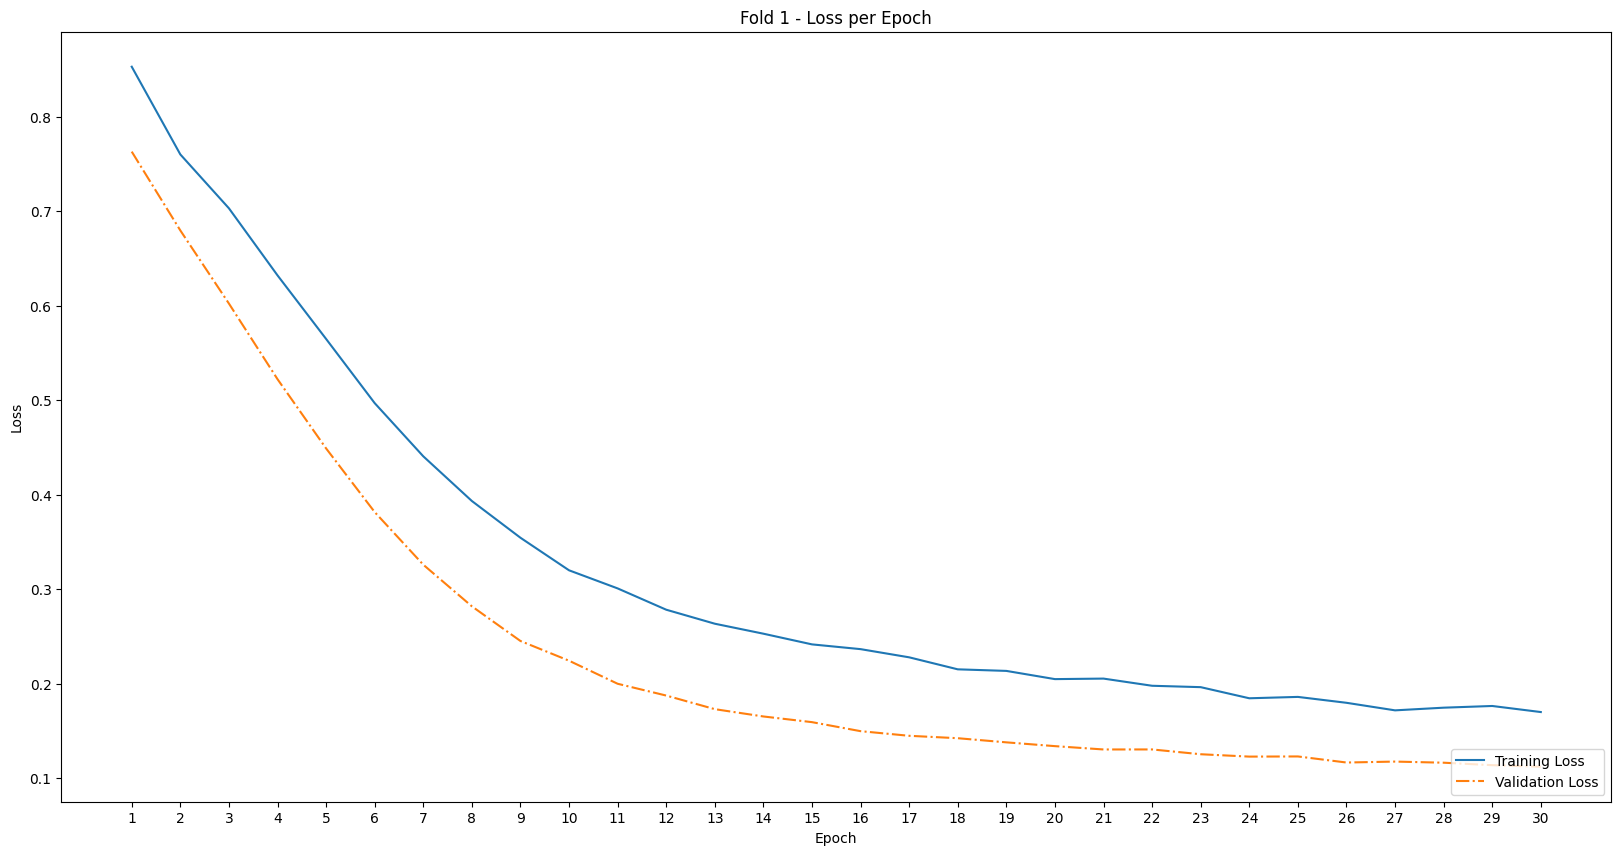

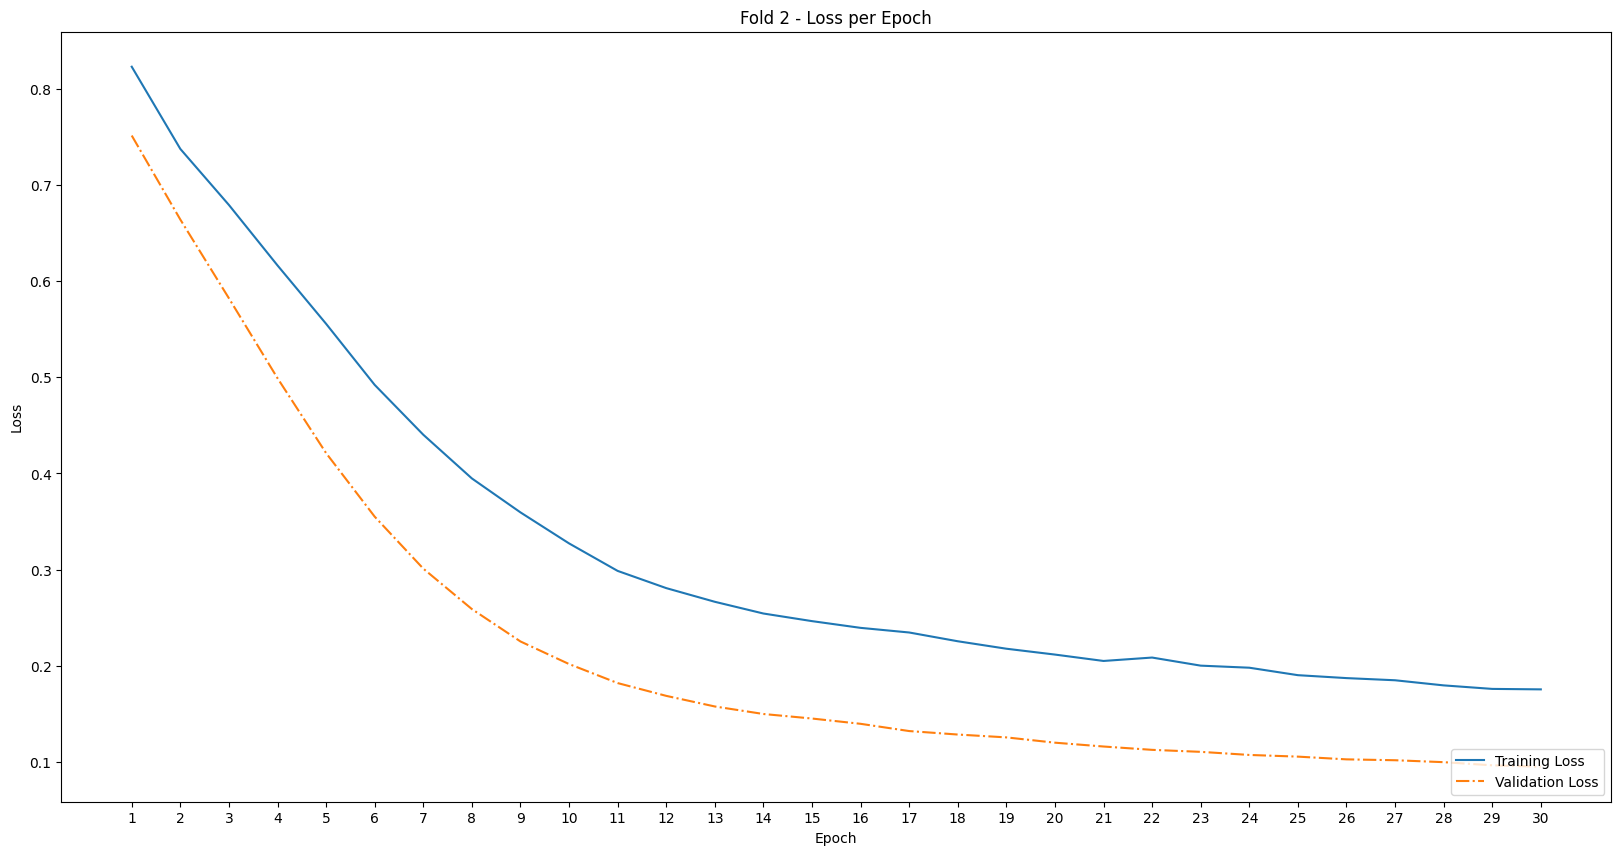

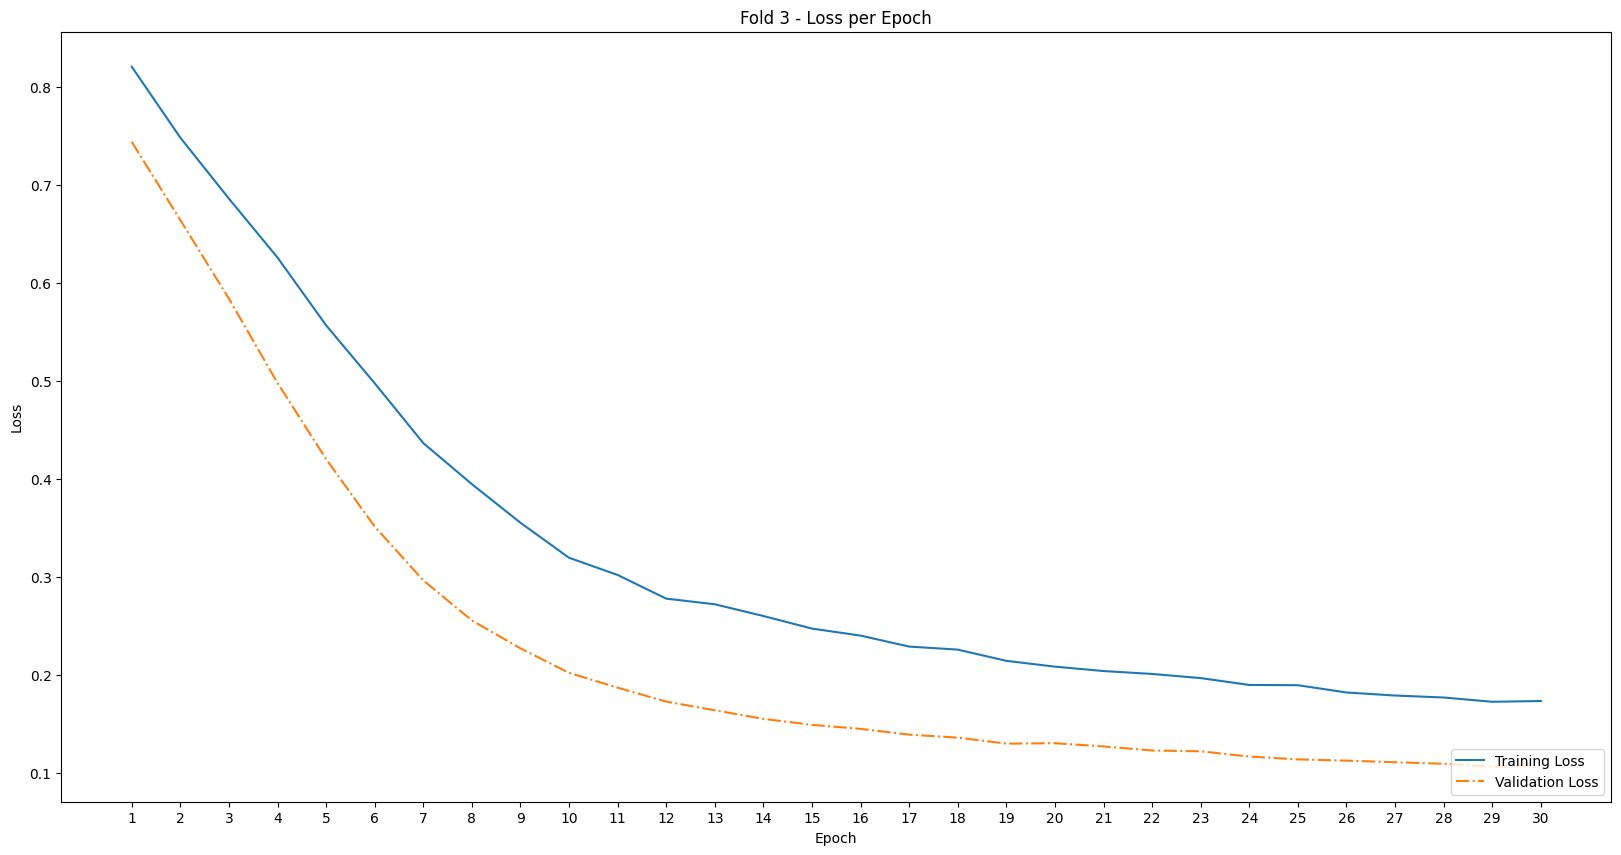

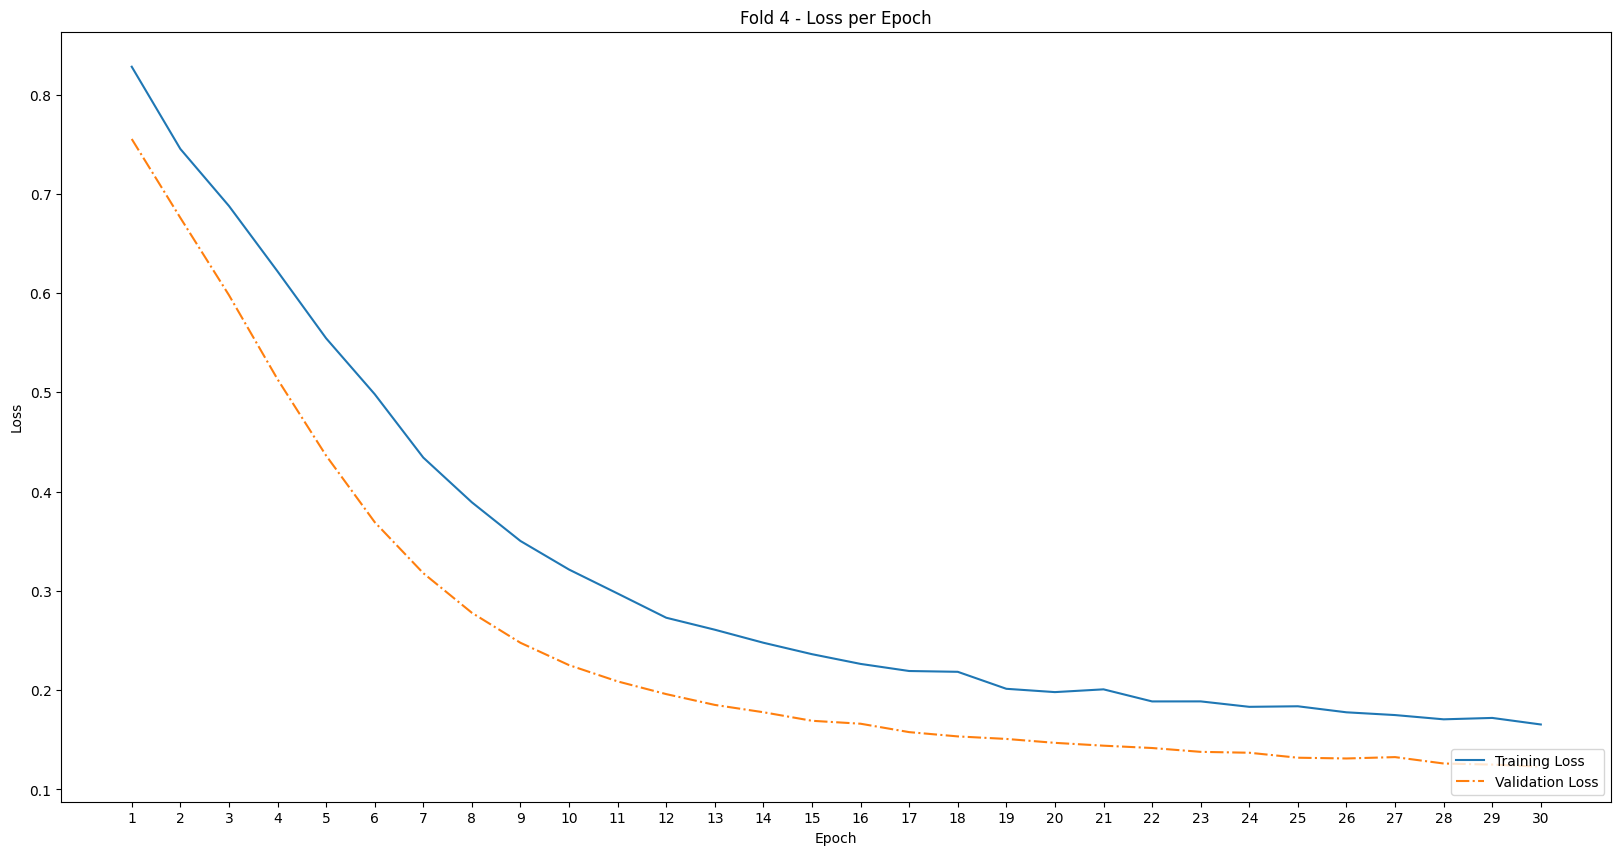

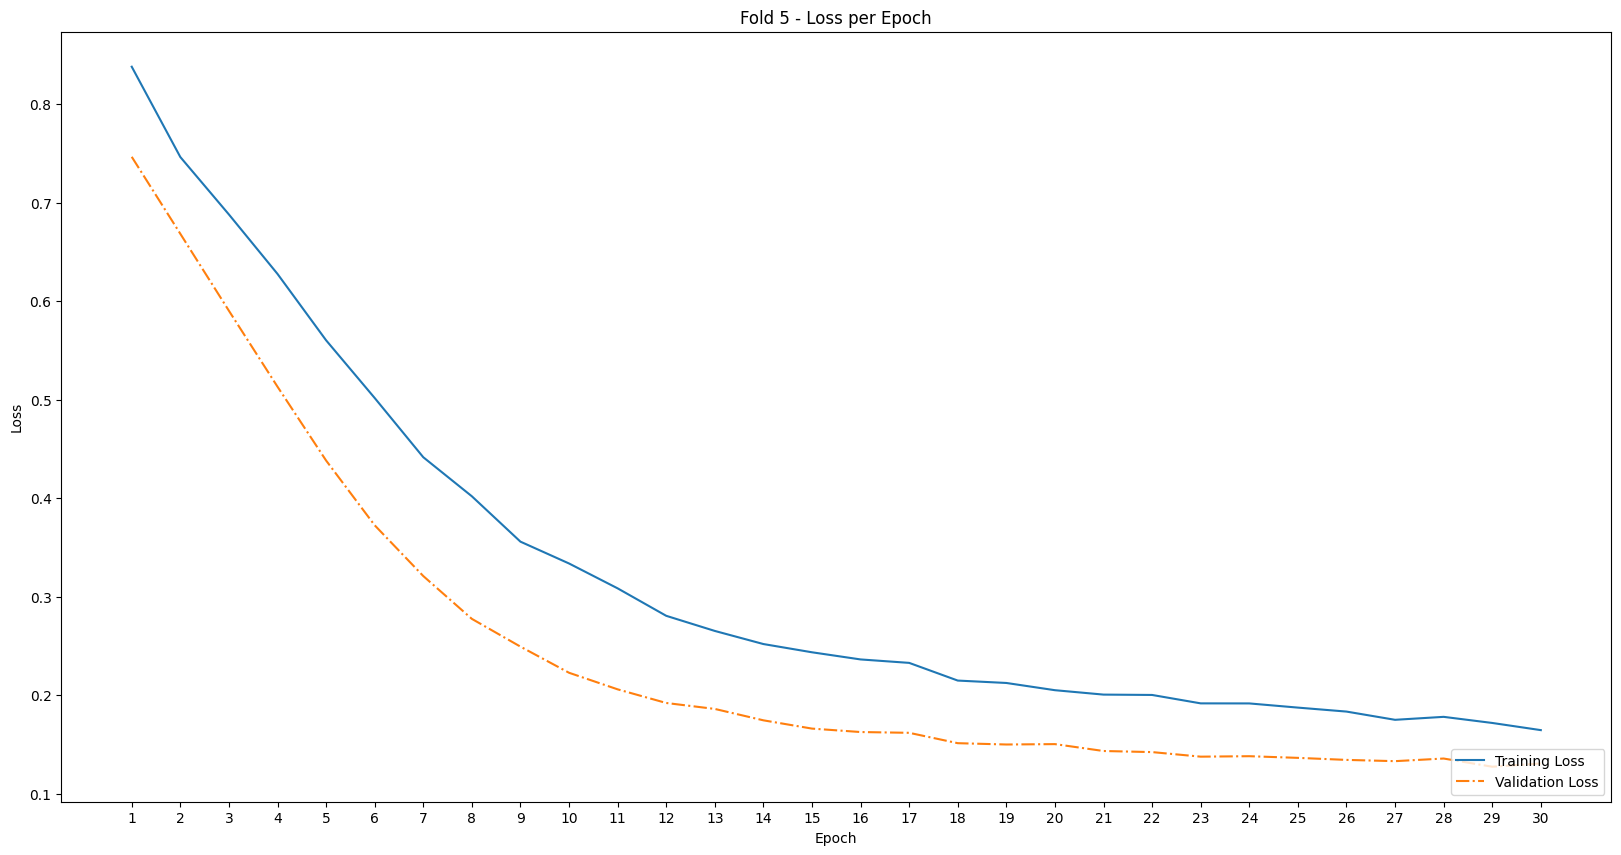

In [24]:
for i in range(5):
  x = np.arange(1, 31)
  y_train_loss = np.asarray(training_losses[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_losses[i], dtype=np.float32)

  plt.figure(figsize=(20,10))

  plt.plot(x, y_train_loss[0:30])
  plt.plot(x, y_val_loss[0:30], '-.')

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'Fold {i + 1} - Loss per Epoch')
  plt.show()

# Testing

Debug Amount: tensor([143., 169., 191., 139., 185., 157., 111.,  15.,   6.,  84.,  17., 121.,
        169.])

Average loss di testing data: 0.00543050881455706


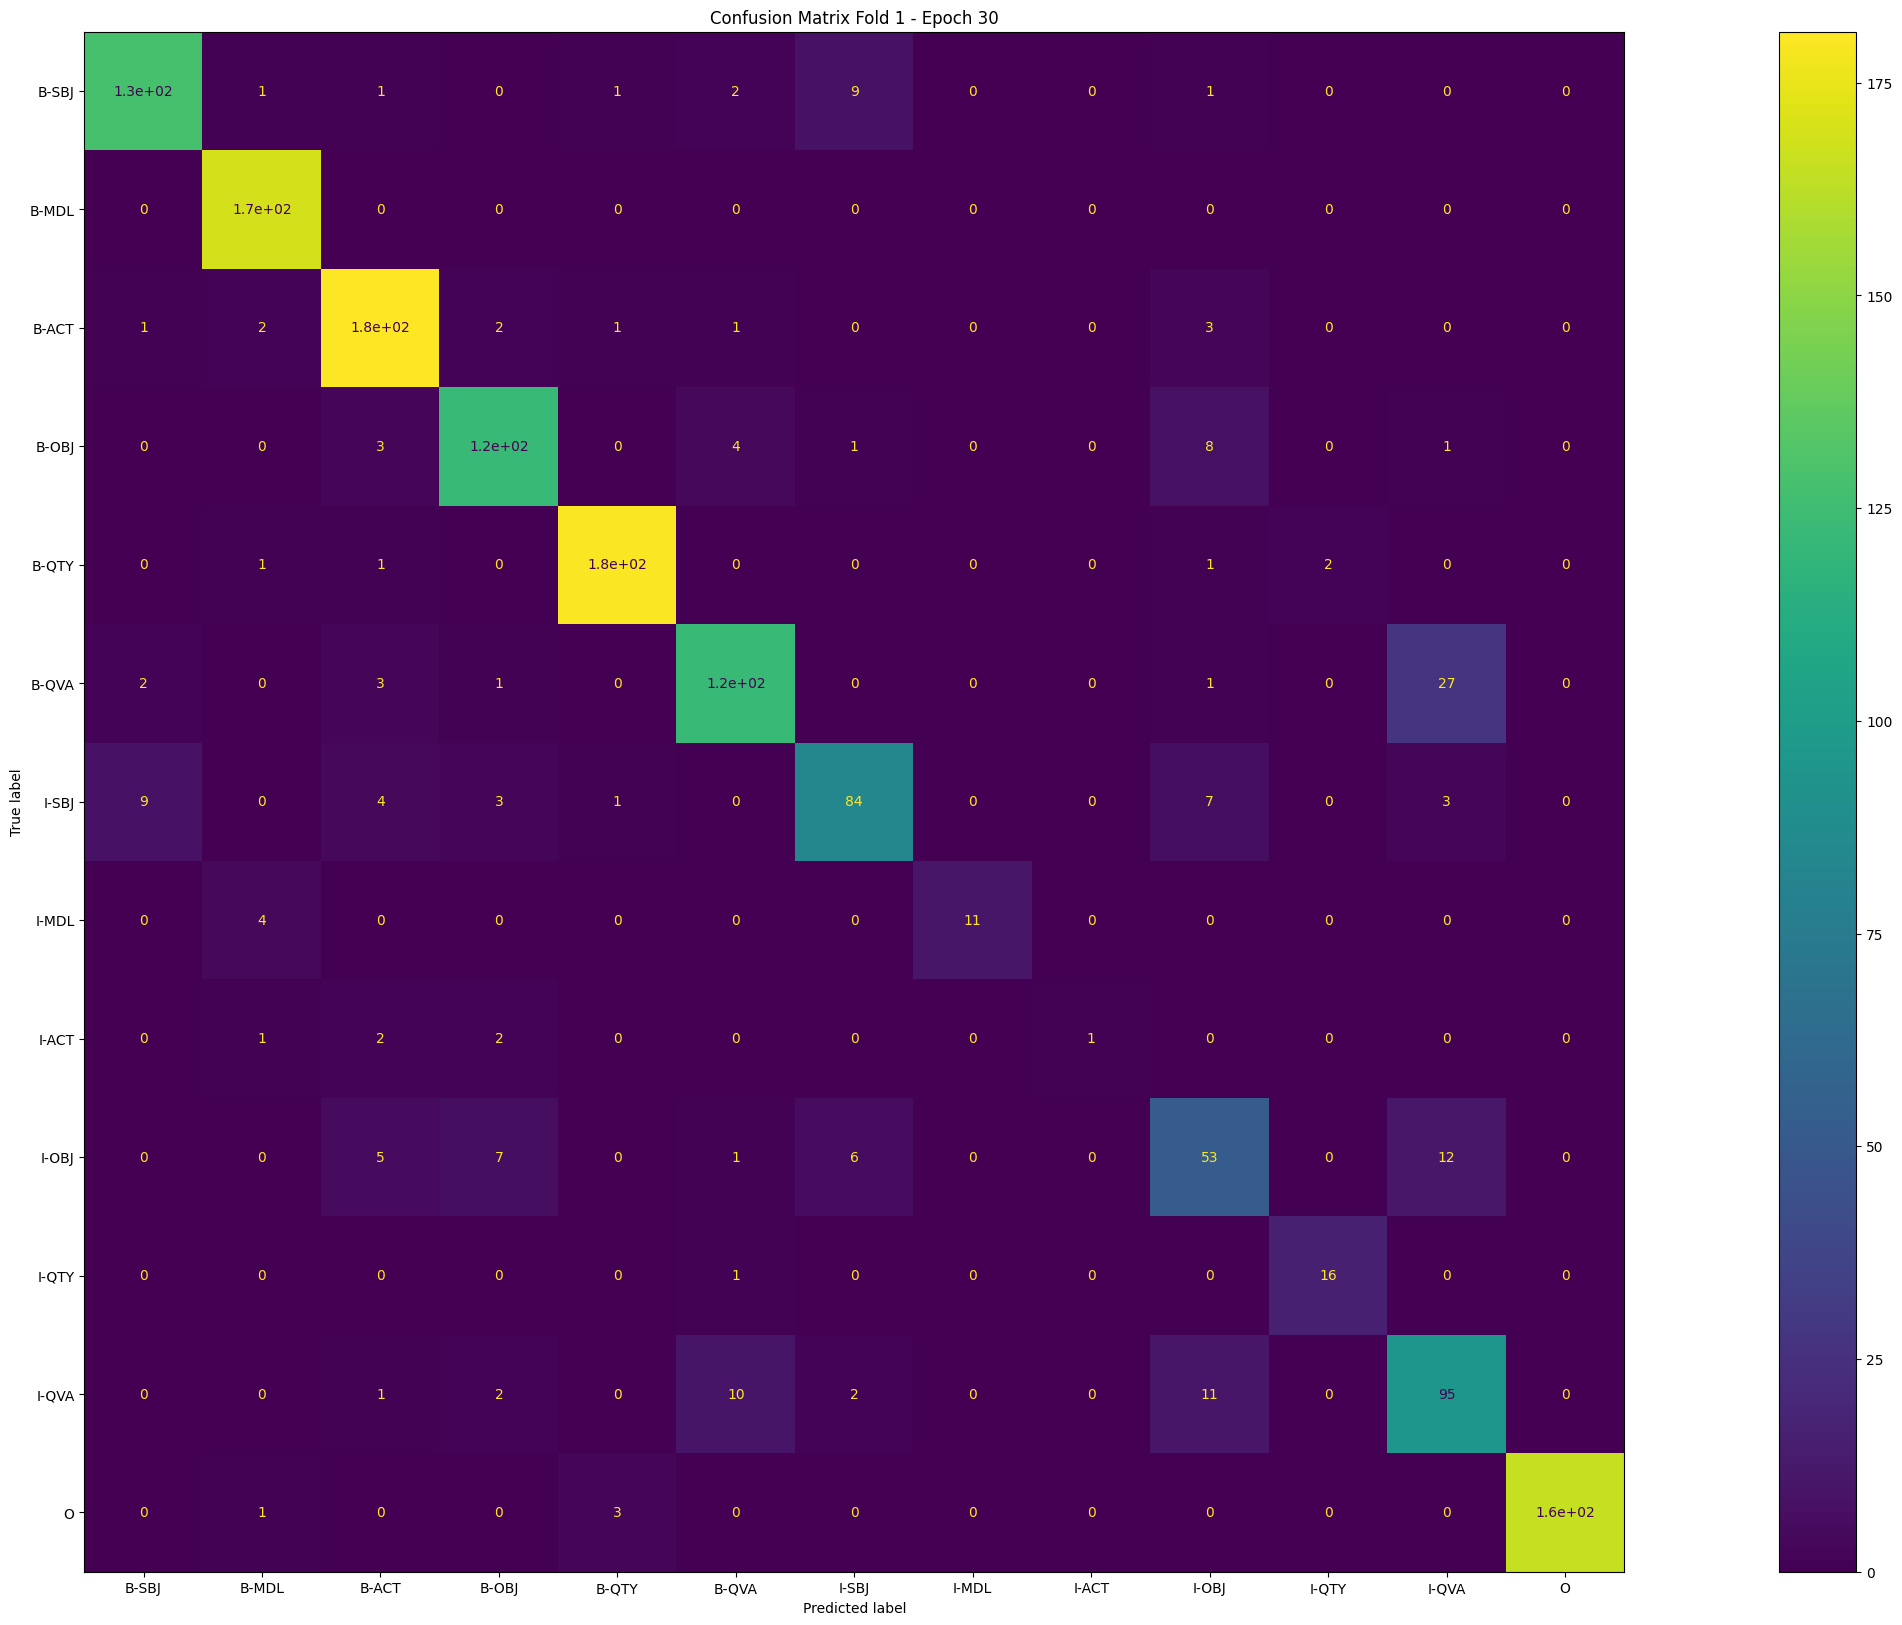

,Amount of Data,Accuracy,Precision,Recall,F One
B-SBJ,143.0,0.895105,0.895105,0.914286,0.904594
B-MDL,169.0,1.000000,1.000000,0.944134,0.971264
B-ACT,191.0,0.947644,0.947644,0.900497,0.923469
B-OBJ,139.0,0.877698,0.877698,0.877698,0.877698
B-QTY,185.0,0.972973,0.972973,0.967742,0.970350
B-QVA,157.0,0.783440,0.783440,0.866197,0.822742
I-SBJ,111.0,0.756757,0.756757,0.823529,0.788732
I-MDL,15.0,0.733333,0.733333,1.000000,0.846154
I-ACT,6.0,0.166667,0.166667,1.000000,0.285714
I-OBJ,84.0,0.630952,0.630952,0.623529,0.627219


Debug Amount: tensor([143., 169., 191., 139., 185., 157., 111.,  15.,   6.,  84.,  17., 121.,
        169.])

Average loss di testing data: 0.005557490737026274


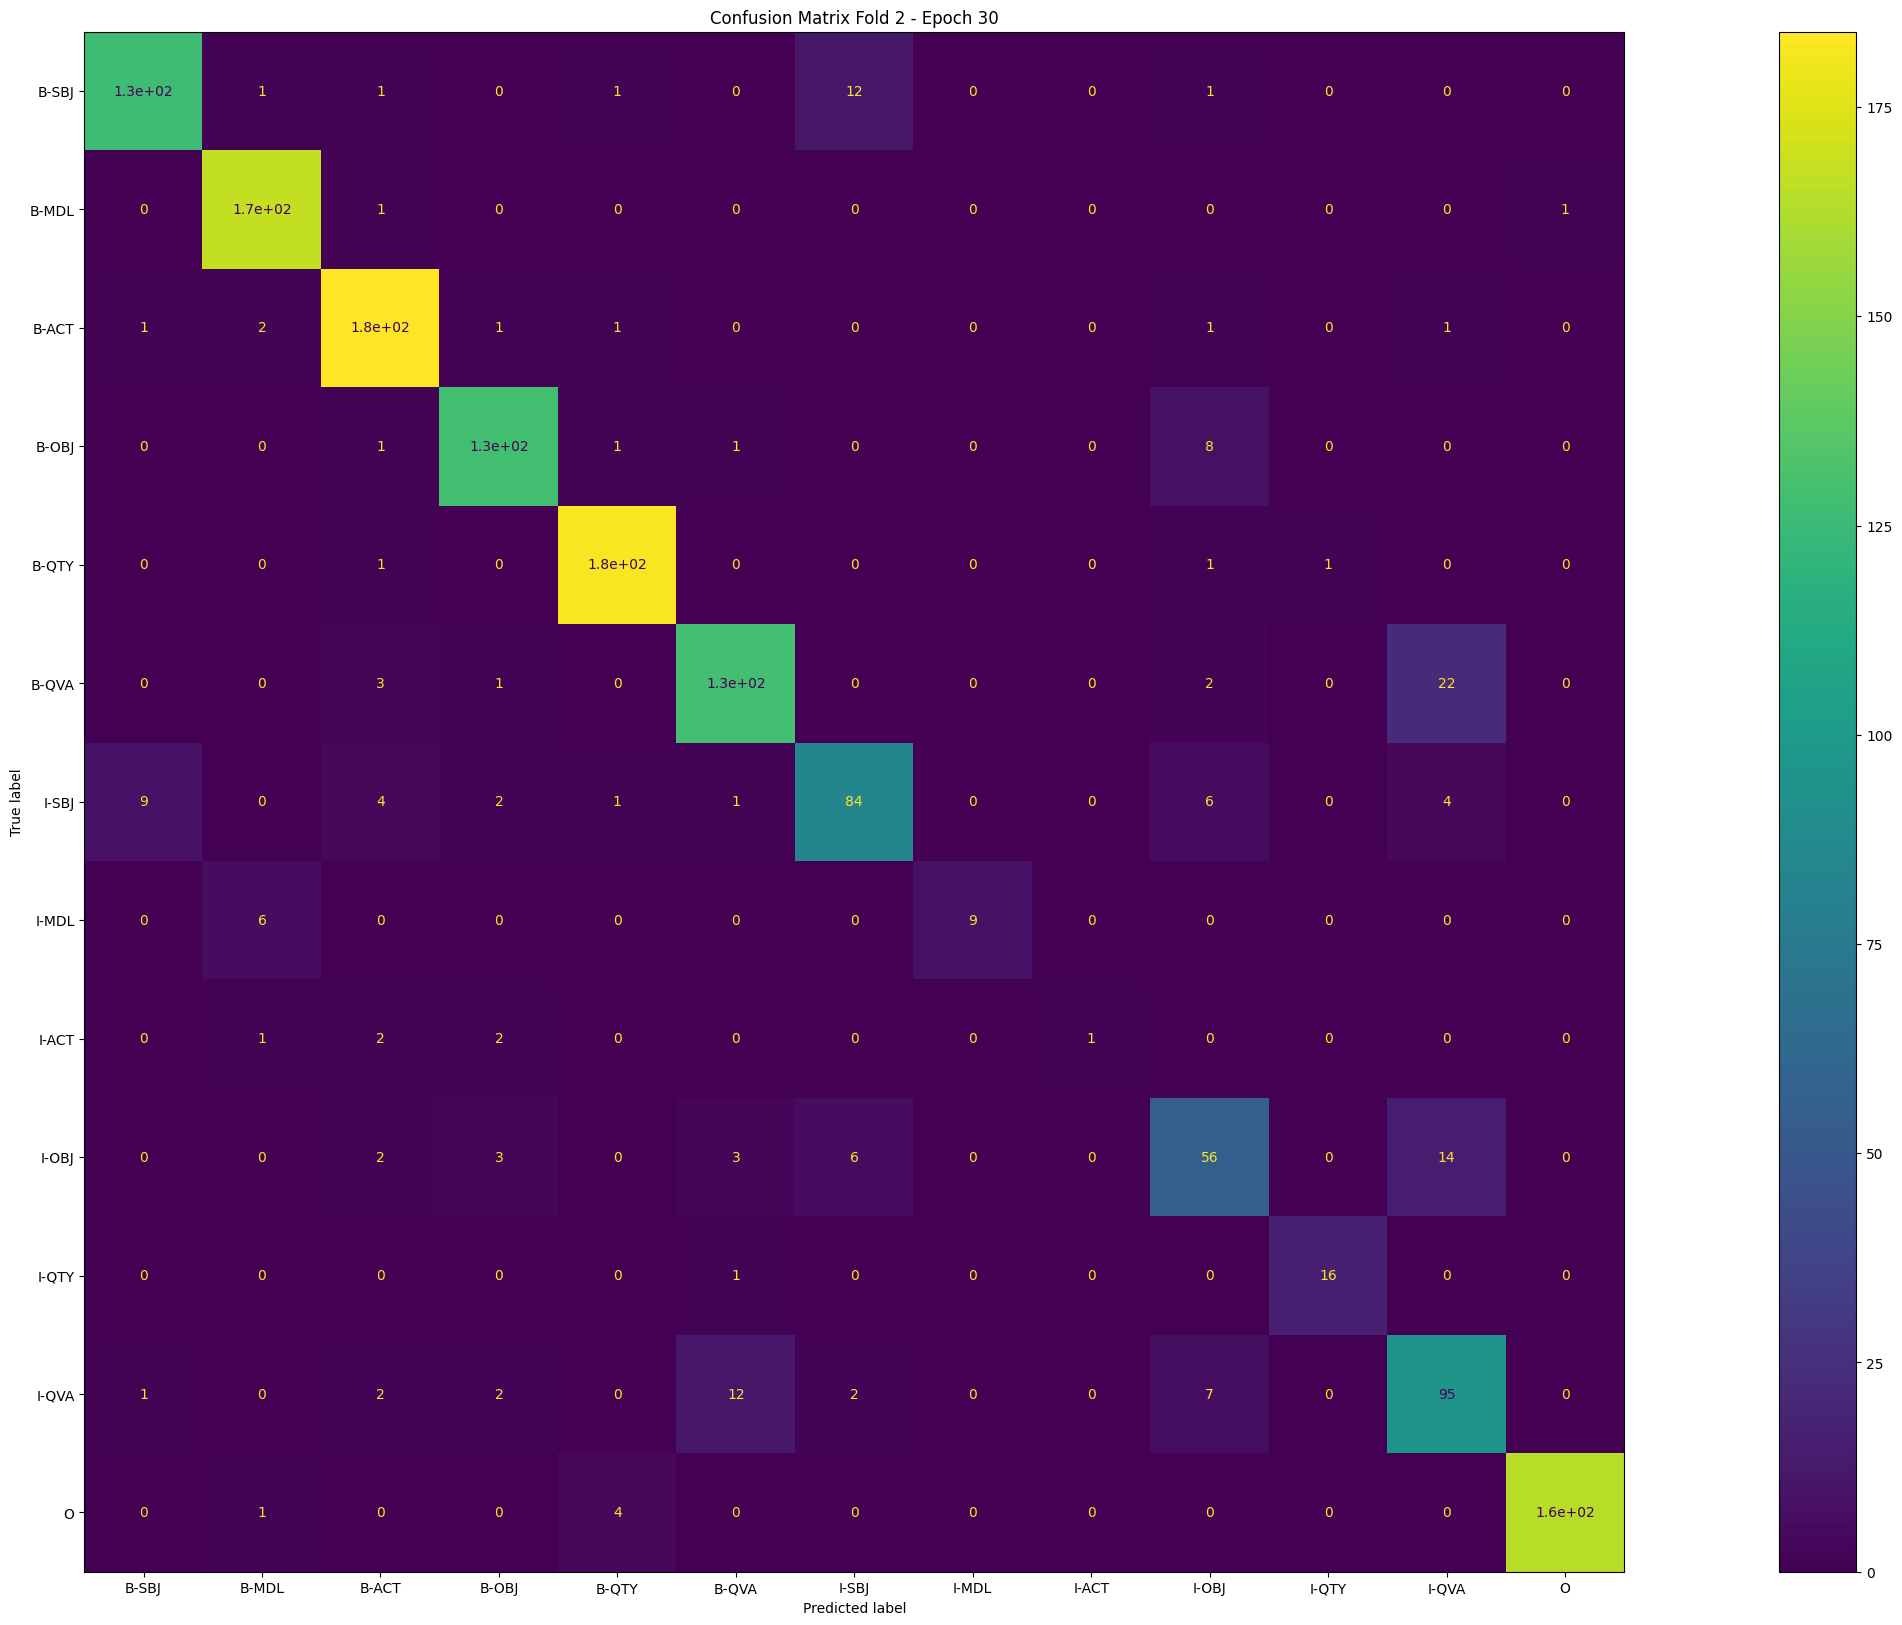

,Amount of Data,Accuracy,Precision,Recall,F One
B-SBJ,143.0,0.888112,0.888112,0.920290,0.903915
B-MDL,169.0,0.988166,0.988166,0.938202,0.962536
B-ACT,191.0,0.963351,0.963351,0.915423,0.938775
B-OBJ,139.0,0.920863,0.920863,0.920863,0.920863
B-QTY,185.0,0.983784,0.983784,0.957895,0.970667
B-QVA,157.0,0.821656,0.821656,0.877551,0.848684
I-SBJ,111.0,0.756757,0.756757,0.807692,0.781395
I-MDL,15.0,0.600000,0.600000,1.000000,0.750000
I-ACT,6.0,0.166667,0.166667,1.000000,0.285714
I-OBJ,84.0,0.666667,0.666667,0.682927,0.674699


Debug Amount: tensor([143., 169., 191., 139., 185., 157., 111.,  15.,   6.,  84.,  17., 121.,
        169.])

Average loss di testing data: 0.005335967890255114


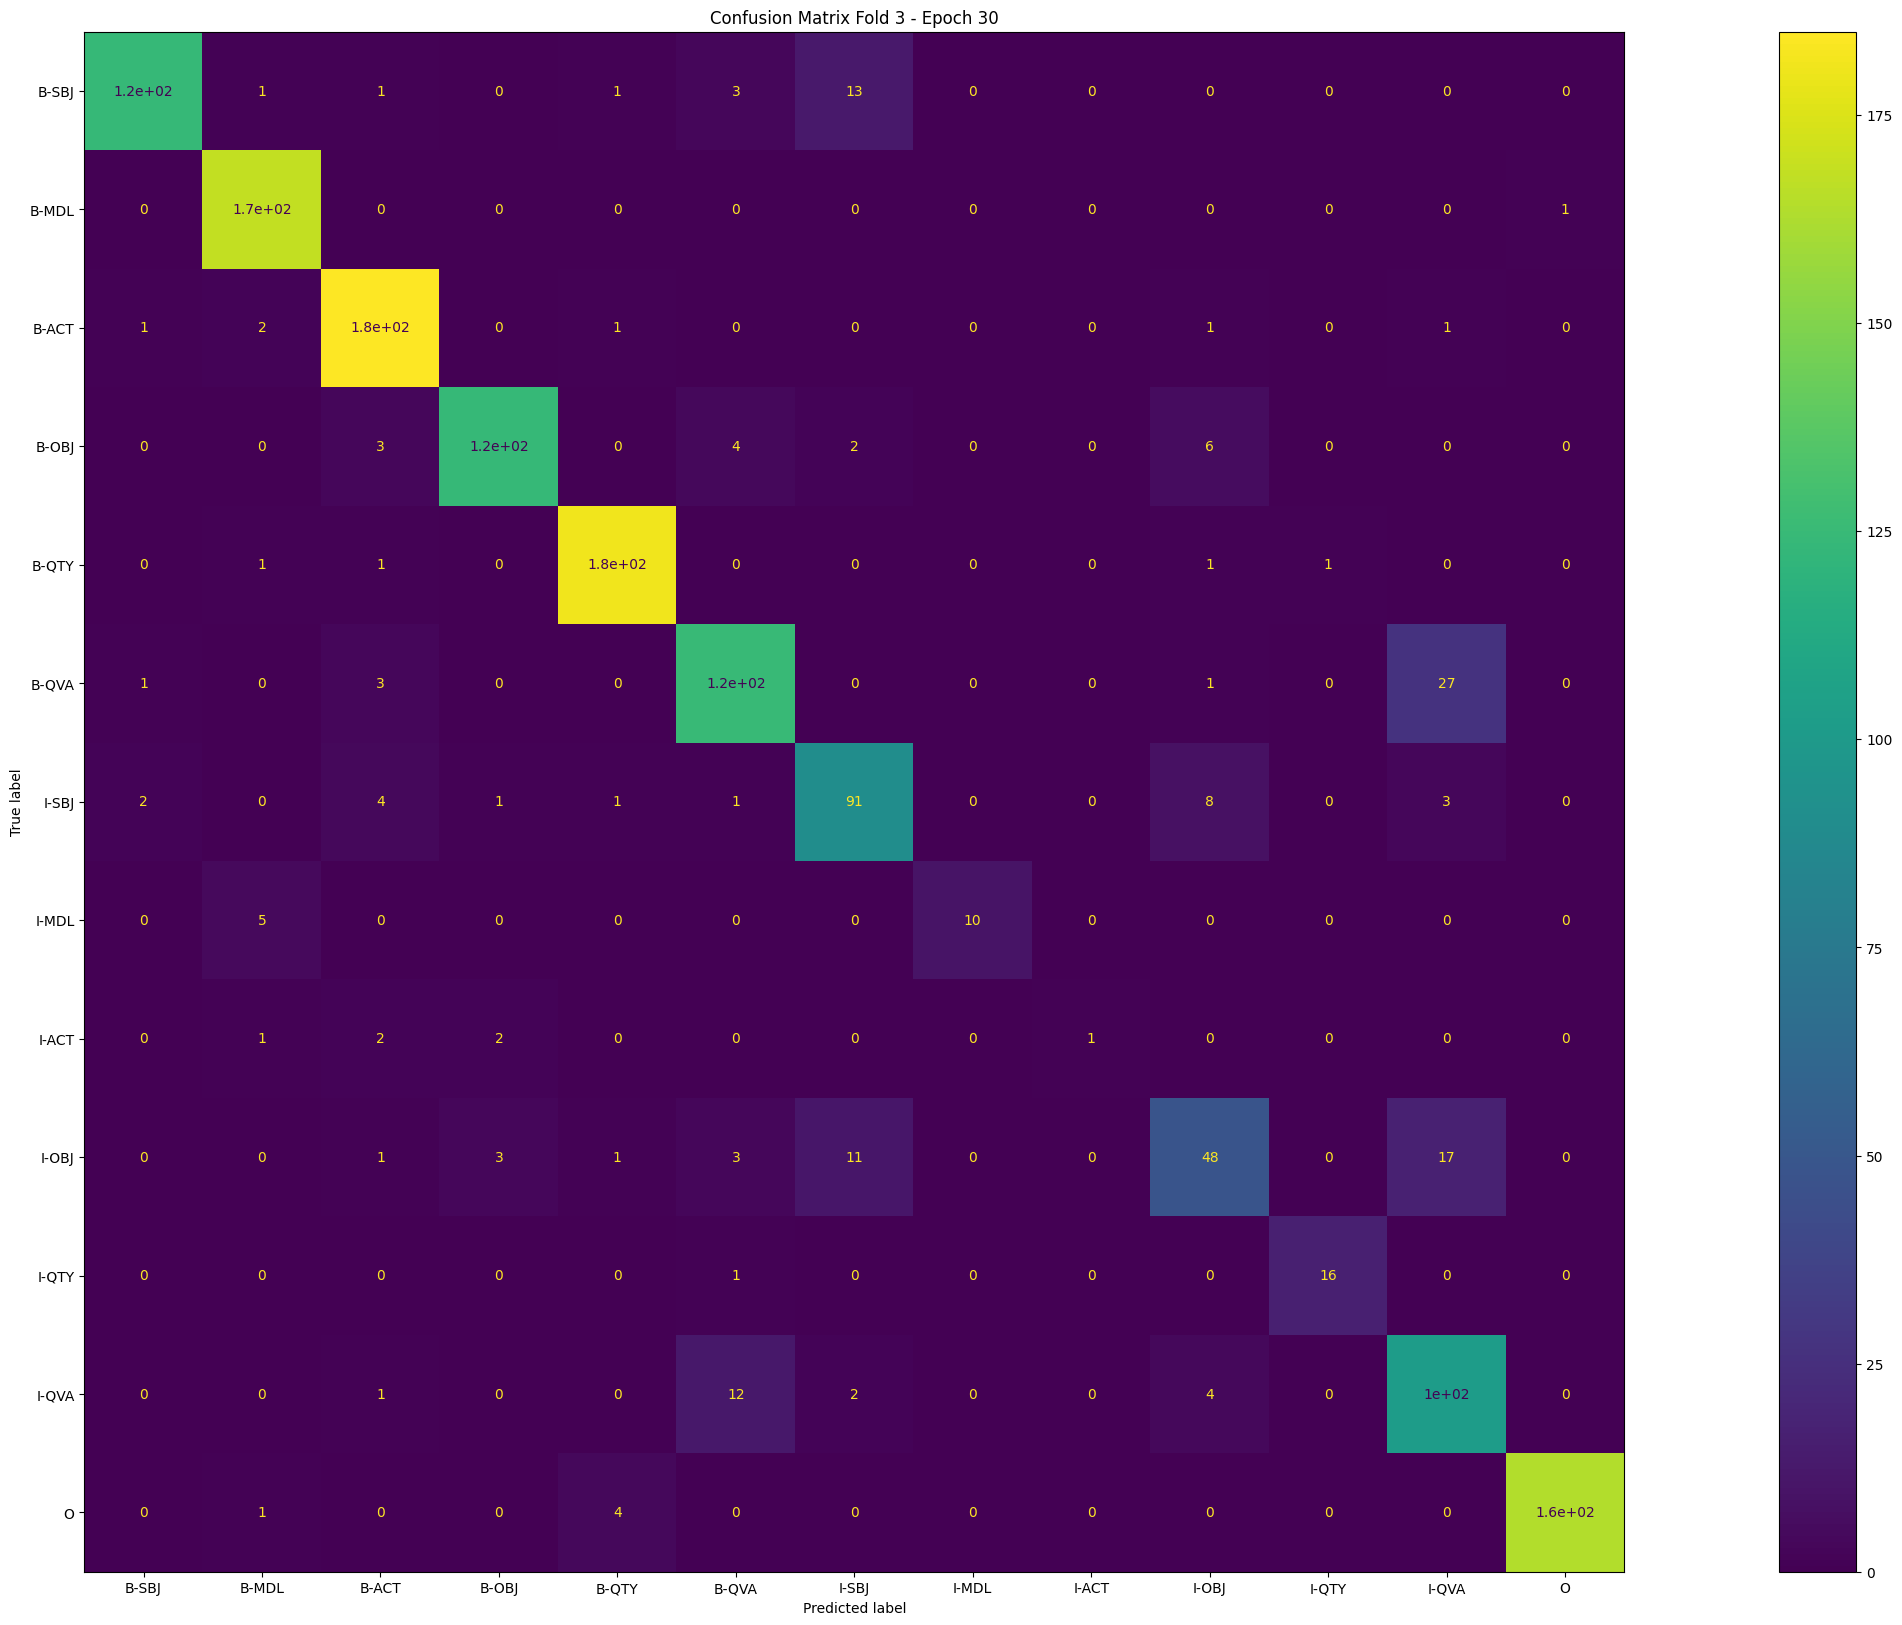

,Amount of Data,Accuracy,Precision,Recall,F One
B-SBJ,143.0,0.867133,0.867133,0.968750,0.915129
B-MDL,169.0,0.994083,0.994083,0.938547,0.965517
B-ACT,191.0,0.968586,0.968586,0.920398,0.943878
B-OBJ,139.0,0.892086,0.892086,0.953846,0.921933
B-QTY,185.0,0.978378,0.978378,0.957672,0.967914
B-QVA,157.0,0.796178,0.796178,0.838926,0.816994
I-SBJ,111.0,0.819820,0.819820,0.764706,0.791304
I-MDL,15.0,0.666667,0.666667,1.000000,0.800000
I-ACT,6.0,0.166667,0.166667,1.000000,0.285714
I-OBJ,84.0,0.571429,0.571429,0.695652,0.627451


Debug Amount: tensor([143., 169., 191., 139., 185., 157., 111.,  15.,   6.,  84.,  17., 121.,
        169.])

Average loss di testing data: 0.005372048516548117


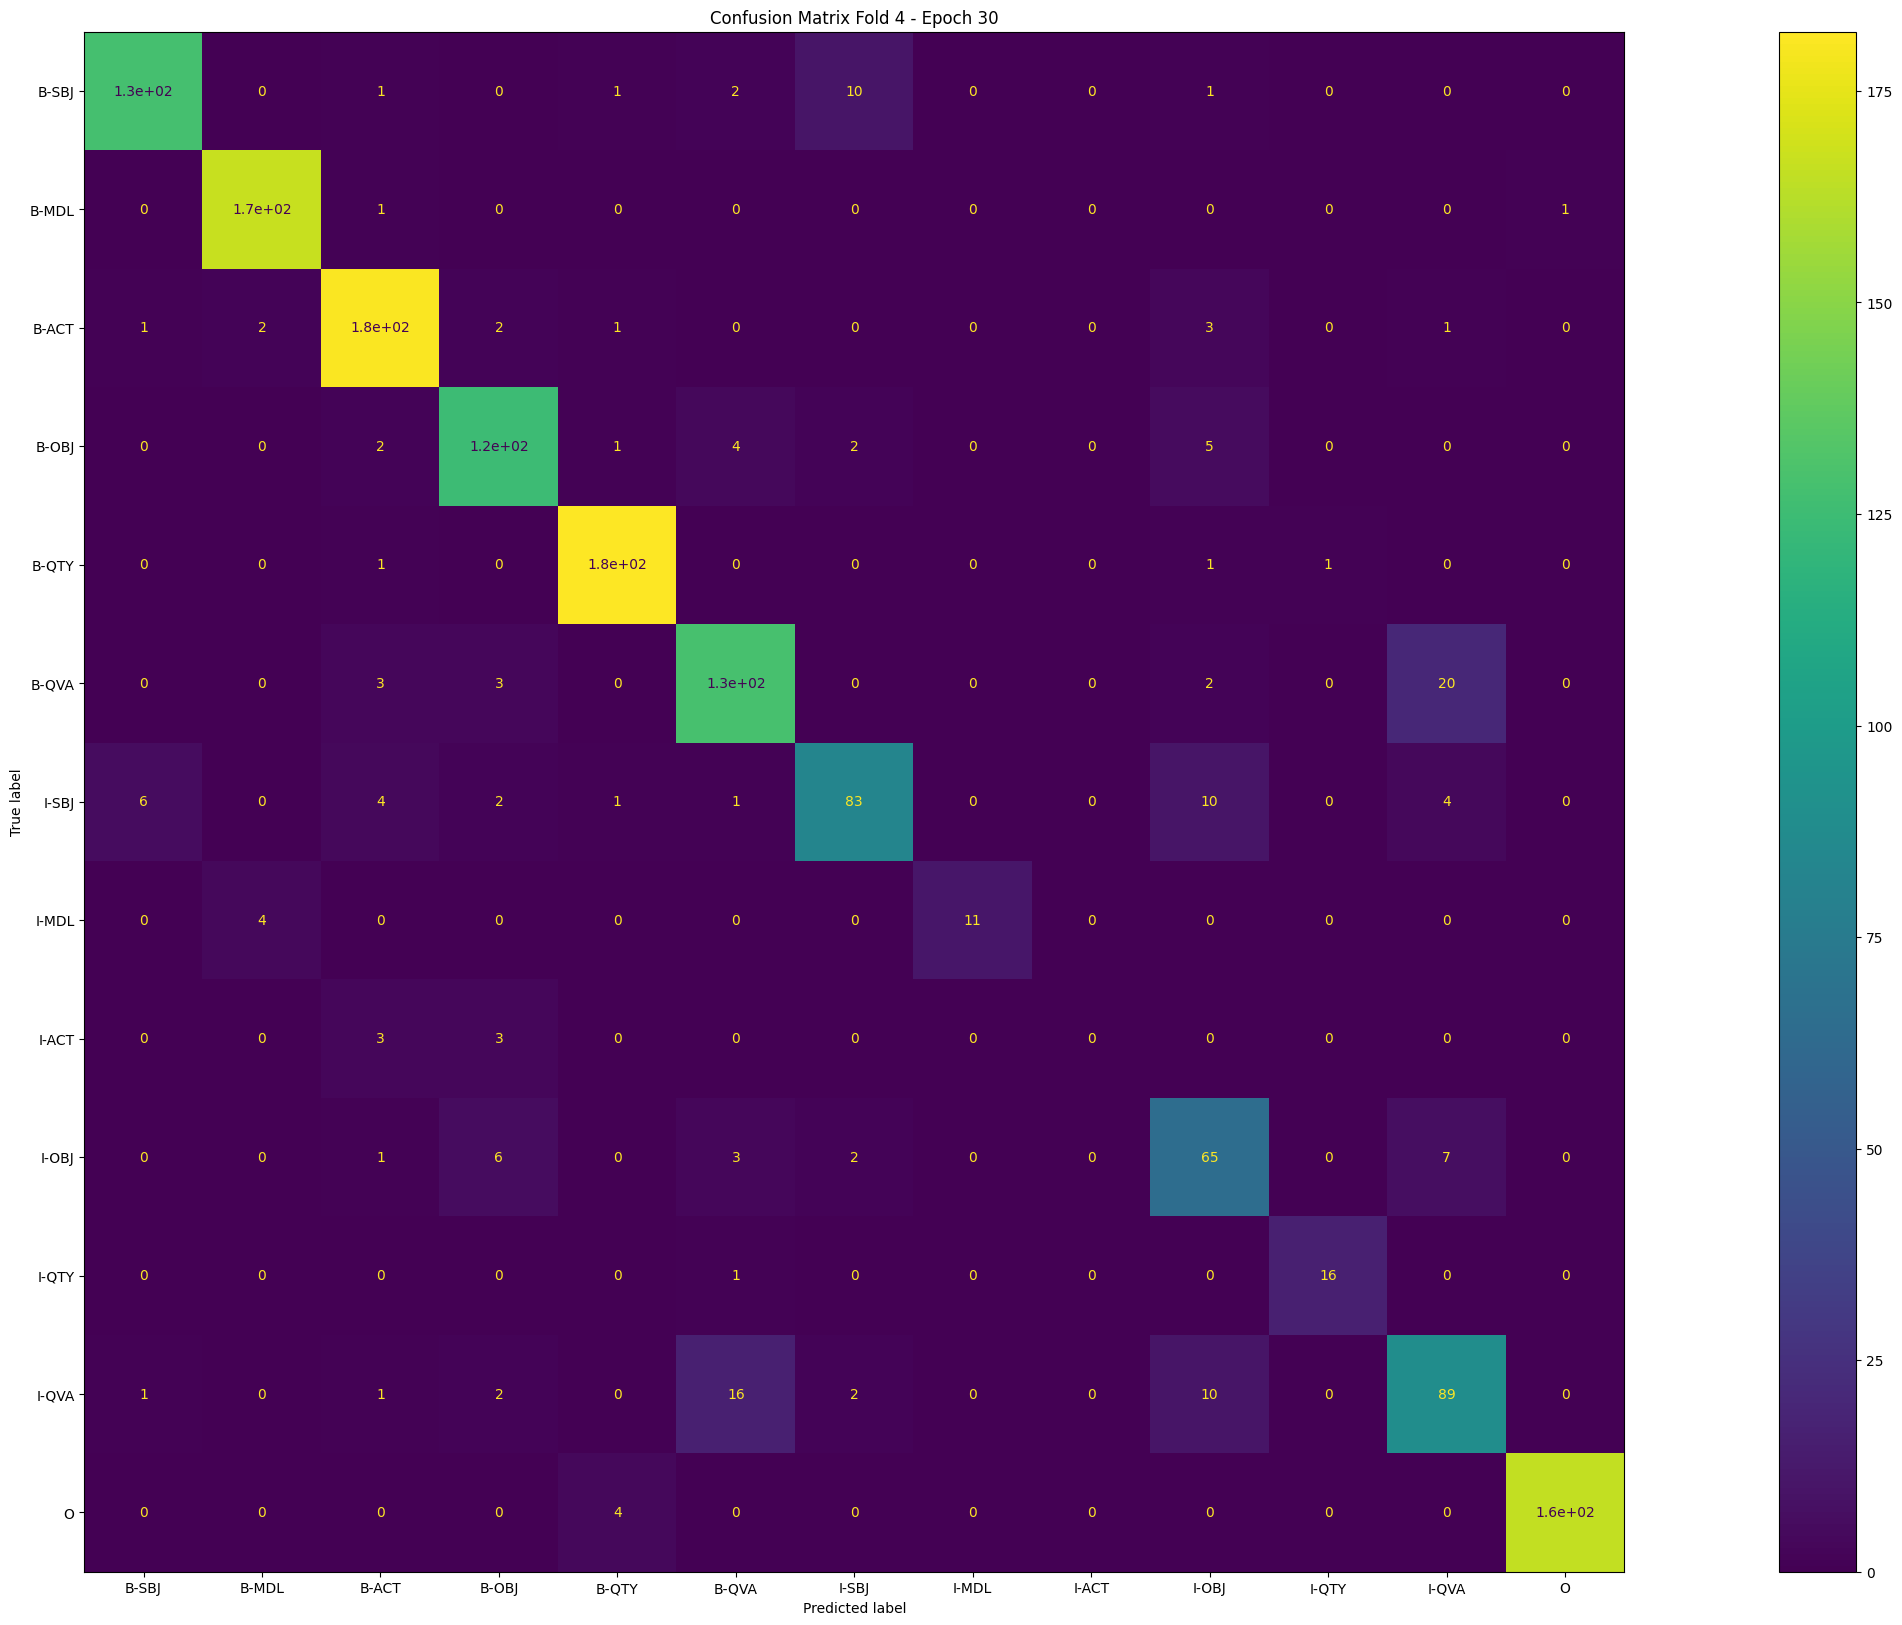

,Amount of Data,Accuracy,Precision,Recall,F One
B-SBJ,143.0,0.895105,0.895105,0.941176,0.917563
B-MDL,169.0,0.988166,0.988166,0.965318,0.976608
B-ACT,191.0,0.947644,0.947644,0.914141,0.930591
B-OBJ,139.0,0.899281,0.899281,0.874126,0.886525
B-QTY,185.0,0.983784,0.983784,0.957895,0.970667
B-QVA,157.0,0.821656,0.821656,0.826923,0.824281
I-SBJ,111.0,0.747748,0.747748,0.838384,0.790476
I-MDL,15.0,0.733333,0.733333,1.000000,0.846154
I-ACT,6.0,0.000000,0.000000,NaN,NaN
I-OBJ,84.0,0.773810,0.773810,0.670103,0.718232


Debug Amount: tensor([143., 169., 191., 139., 185., 157., 111.,  15.,   6.,  84.,  17., 121.,
        169.])

Average loss di testing data: 0.005468015895464033


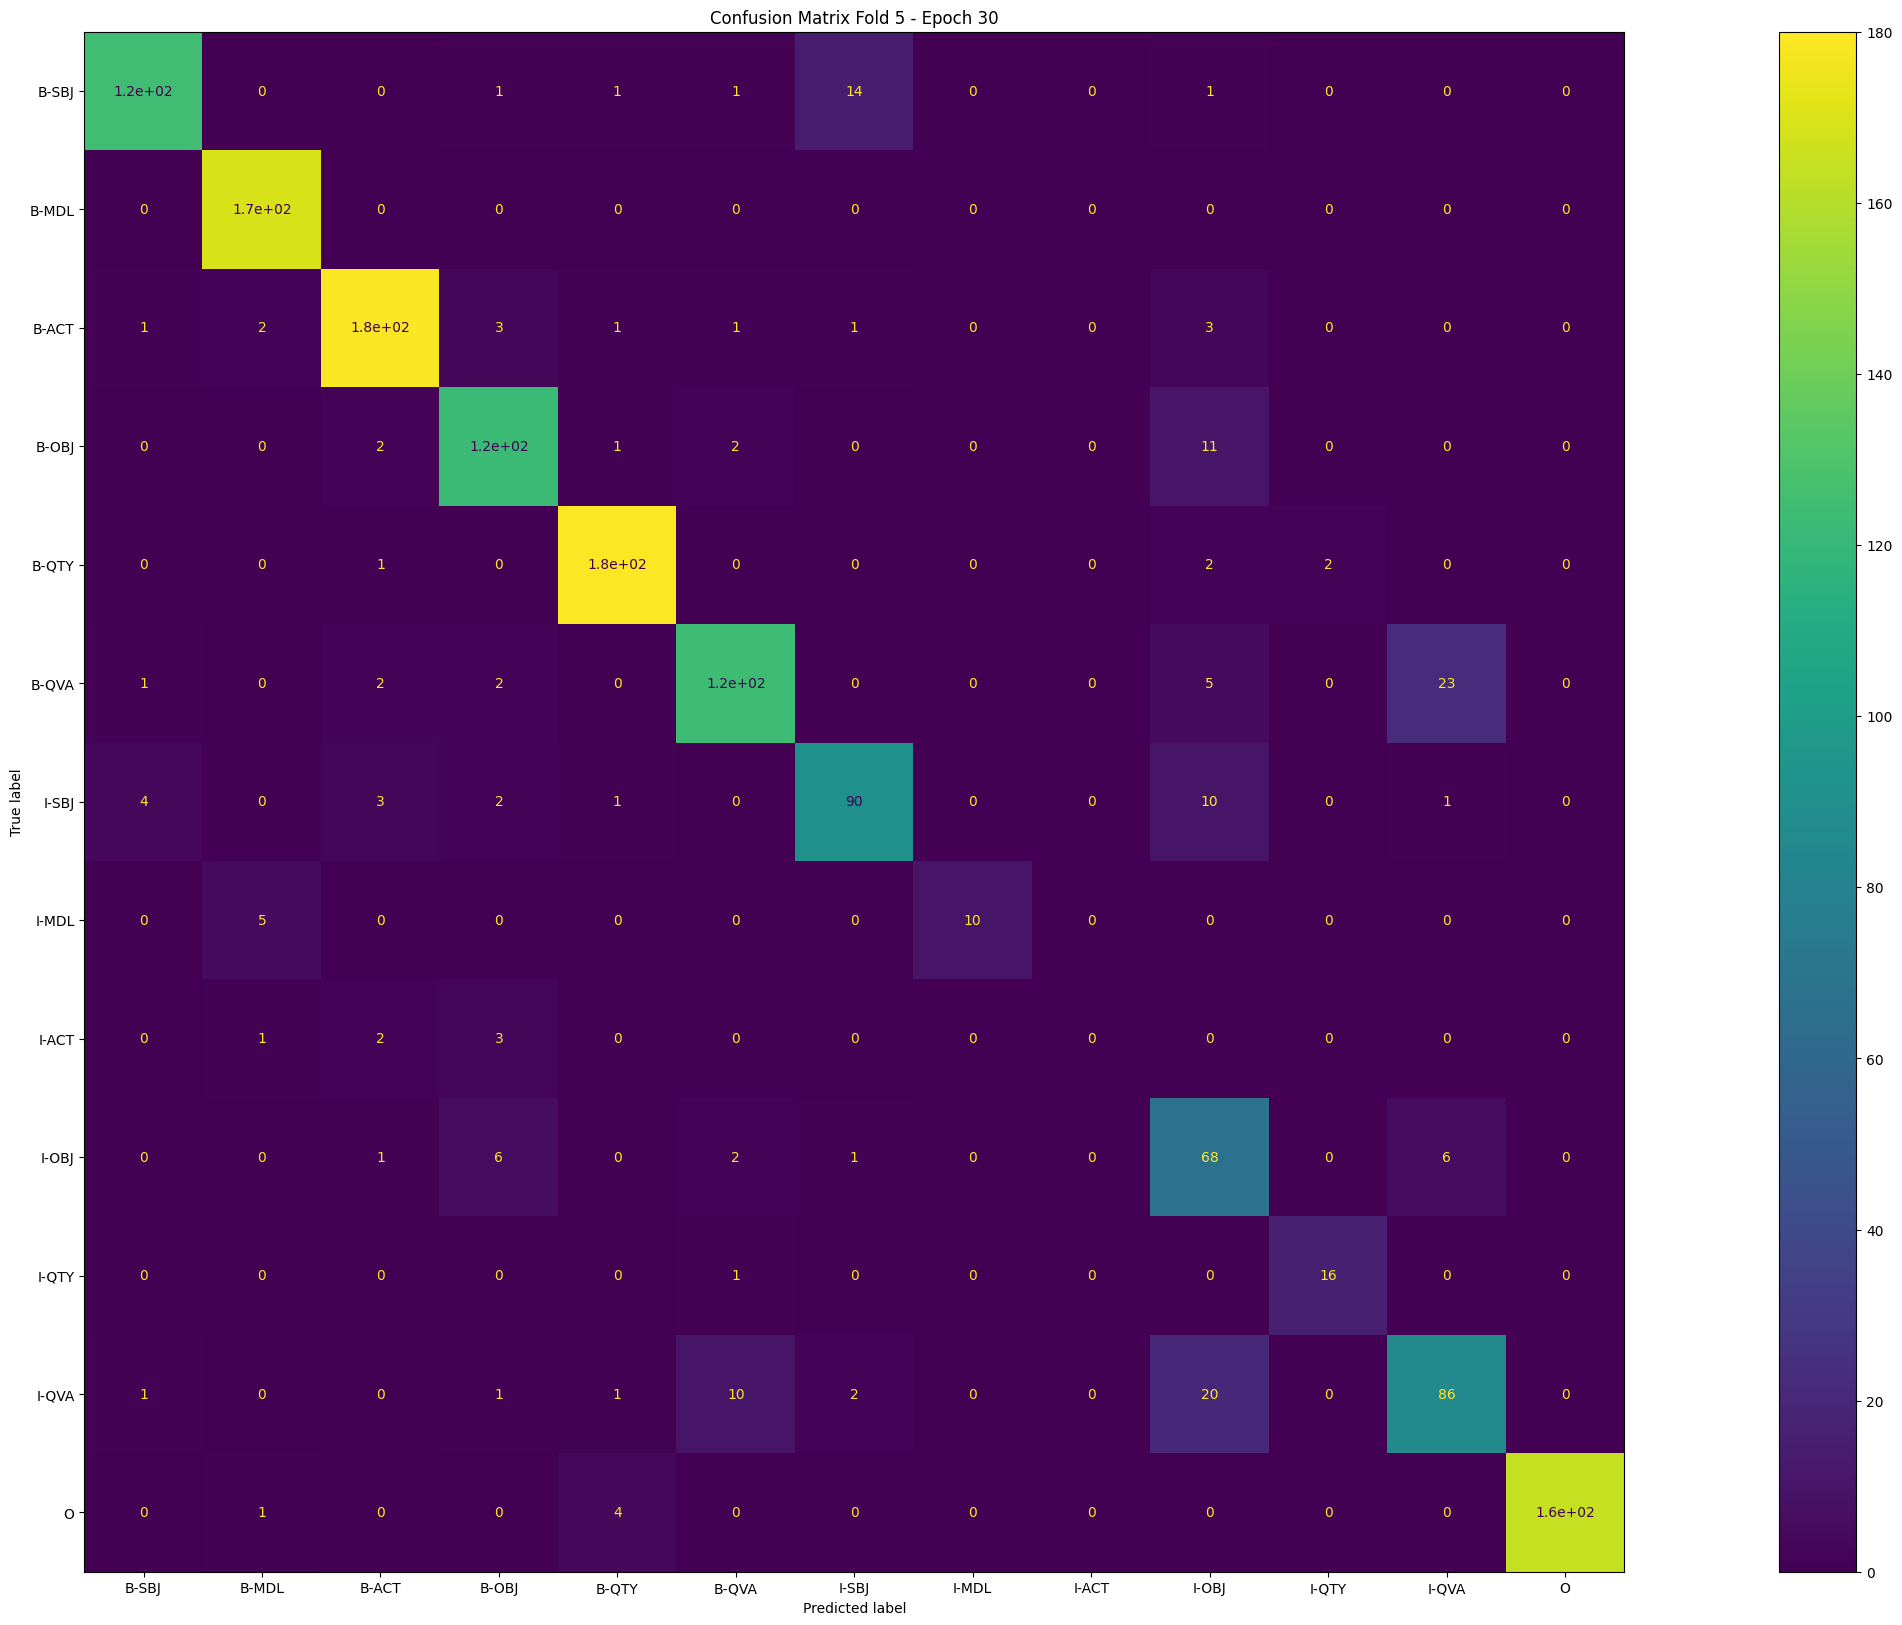

,Amount of Data,Accuracy,Precision,Recall,F One
B-SBJ,143.0,0.874126,0.874126,0.946970,0.909091
B-MDL,169.0,1.000000,1.000000,0.949438,0.974063
B-ACT,191.0,0.937173,0.937173,0.942105,0.939633
B-OBJ,139.0,0.884892,0.884892,0.872340,0.878571
B-QTY,185.0,0.972973,0.972973,0.952381,0.962567
B-QVA,157.0,0.789809,0.789809,0.879433,0.832215
I-SBJ,111.0,0.810811,0.810811,0.833333,0.821918
I-MDL,15.0,0.666667,0.666667,1.000000,0.800000
I-ACT,6.0,0.000000,0.000000,NaN,NaN
I-OBJ,84.0,0.809524,0.809524,0.566667,0.666667


In [31]:
true_recaps = [[] for i in range(5)]
false_recaps = [[] for i in range(5)]

for fold_i in range(5):

  tr_loss = 0

  save_path = 'model_semantic/ner_bio_checkpoint/fold_' + str(fold_i)
  model_class_path = os.path.join(save_path, "indobert_ner_semantic_checkpoint_29.pth")
  model = torch.load(model_class_path)

  model.to(DEVICE)

  model.eval()

  nb_classes = 13

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, attention, gold = data
      input = input.to(DEVICE)
      attention = attention.to(DEVICE)
      gold = gold.to(DEVICE)
      logits = model(input, attention_mask=attention).logits
      pred = torch.argmax(logits, dim=2)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(logits.permute(0, 2, 1), gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(pred, gold, conf_matrix)

      for input_recap, gold_recap, pred_recap in zip(input.to('cpu'), gold.to('cpu'), pred.to('cpu')):
        input_recap_sentence = tokenizer.decode(input_recap)
        # _, gold_idx = torch.max(gold_recap, 0)
        # _, pred_idx = torch.max(pred_recap, 0)
        if torch.equal(gold_recap, pred_recap):
          true_recaps[fold_i].append((input_recap_sentence, gold_recap, pred_recap))
        else:
          false_recaps[fold_i].append((input_recap_sentence, gold_recap, pred_recap))

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
  data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print("")
  print(f"Average loss di testing data: {avg_loss}")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['B-SBJ', 'B-MDL', 'B-ACT', 'B-OBJ', 'B-QTY', 'B-QVA', 'I-SBJ', 'I-MDL', 'I-ACT', 'I-OBJ', 'I-QTY', 'I-QVA', 'O']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)
  plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch 30")

  plt.show()

  disp_df = pd.DataFrame(data=data_conf,
                          index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
  display(disp_df)

In [26]:
save_path = 'model_semantic/ner_bio_checkpoint/fold_2'
model_class_path = os.path.join(save_path, "indobert_ner_semantic_checkpoint_29.pth")
model = torch.load(model_class_path)

# bert_class = model_class

save_path = 'model/ner/'
!mkdir -p model/ner/
model_class_path = os.path.join(save_path, "indobert_ner_bio_semantic"+".pth")

model.to('cpu')
torch.save(model, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
df_true_recaps = pd.DataFrame(true_recaps[2], columns=['question', 'true_label', 'pred_label'])

save_path = 'semantic/dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_true_recaps.to_csv('semantic/dataset/indobert_ner_bio_true_recaps.csv', index=False)

In [34]:
df_false_recaps = pd.DataFrame(false_recaps[2], columns=['question', 'true_label', 'pred_label'])

save_path = 'semantic/dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_false_recaps.to_csv('semantic/dataset/indobert_ner_bio_false_recaps.csv', index=False)